In [46]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm
import math
from scipy.integrate import quad

# Step 1: Generate the data 
I'm aiming to generate 20000 datapoints from a Gaussian mixture model of k = 100 components. For simplicity, each datapoint is a scalar (1-dimension). 
To make it more realistic, I will random the weight of each component.

In [127]:
n = 75000 # Number of datapoints
k = 15 # Number of components

# Randomising the weights
weights = np.random.uniform(low = 0.75, high = 1, size=(k, ))
weights = weights / np.sum(weights) 
assert abs(np.sum(weights) - 1) < 0.0000001 # Ensuring a convex linear combination

# Decide which component we will sample from
mixture_index = np.random.choice(k, size = n, replace = True, p = weights)
assert mixture_index.shape == (n, )

# Decide the random mean and variance of all 100 components
mean = np.random.uniform(low=-17.5, high=17.5, size=(k, ))
variance = np.random.uniform(low=0.5, high=2, size=(k, ))


In [128]:
# Generate data using numpy for efficiency
data = np.fromiter((np.random.normal(loc = mean[index], scale = np.sqrt([variance[index]])[0]) for index in mixture_index), float)
assert data.shape == (n, )

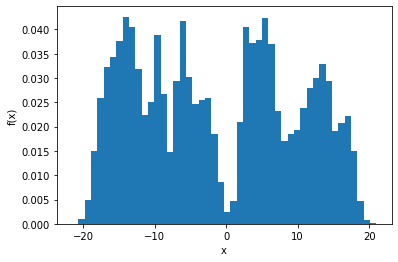

In [129]:
plt.hist(data, bins="auto", density=True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

# Step 2: The traditional EM algorithm
The algorithm includes finding the probability of each point belonging to each component, then tune the mean and variance of each component according the the calculated probabilities. 

In [130]:
# First, define a way to calculate pdf 
def pdf(x, input_mean, input_var):
    
    return math.exp(-0.5 * ((x - input_mean) ** 2 ) / input_var) / (math.sqrt(2 * math.pi * input_var))

# Test the function
assert pdf(0, 0, 1) == 0.3989422804014327
assert pdf(0.5, 0, 1) == 0.3520653267642995


In [131]:
# Define a metric to evaluate our return from EM alg.
# KL divergence is an integral from -inf to +inf, in this case, I only use the n datapoints that we already generated.

# Hardcoded P_value to save time
P_value = np.zeros((n,))
for i in range(n):
    for j in range(k):
        P_value[i] += weights[j] * pdf(data[i], mean[j], variance[j])   
        
        
def KL_div(pred_mean, pred_variance, pred_weights):
    KL_divergence = 0
    for i in range(n):
        Q_value = 0
        for j in range(k):
            Q_value += pred_weights[j] * pdf(data[i], pred_mean[j], pred_variance[j])
            #P_value += weights[j] * pdf(data[i], mean[j], variance[j])
        KL_divergence += P_value[i] * math.log(P_value[i]/Q_value, math.e) - P_value[i] + Q_value
    
    return KL_divergence
    
assert KL_div(mean, variance, weights) == 0



In [135]:
# This implementation is based on Dr. Martha White's notes for CMPUT367, page 107. 

def traditional_EM():
    
    # Starts with random means, variances and weights
    predicted_mean = np.random.uniform(low=-5, high=5, size=(k, ))
    predicted_variance = np.random.uniform(low=0.5, high=5, size=(k, ))
    predicted_weights = np.random.random(size=(k, ))
    predicted_weights = predicted_weights / np.sum(predicted_weights) 
    
    
    divergence_plot = [] # Array for plotting later
    counter = 0 # Count iteration for printing divergence
    
    KL_divergence = KL_div(predicted_mean, predicted_variance, predicted_weights)
    print("kl div:", KL_divergence)
    prev_divergence = math.inf
    
    probability_matrix = np.zeros((n, k))
    normalised_p_matrix = np.zeros((n, k))
    
    while prev_divergence - KL_divergence > 0.0001 and KL_divergence > 0:
        
        for i in range(n):
            denominator_sum = 0
            for j in range(k):
                probability_matrix[i, j] = predicted_weights[j] * pdf(data[i], predicted_mean[j], predicted_variance[j])
            
            denominator_sum = np.sum(probability_matrix[i, :])
            
            probability_matrix[i, :] = probability_matrix[i, :] / denominator_sum
        
        
        for j in range(k):
            normalised_p_matrix[:, j] = probability_matrix[:, j] / np.sum(probability_matrix[:, j])
            
                
        
        for j in range(k):
            
            predicted_weights[j] = (1/n) * np.sum(probability_matrix[:, j])
            predicted_mean[j] = np.sum(normalised_p_matrix[:, j] * data)
            
            predicted_variance[j] = np.sum(normalised_p_matrix[:, j] * (data - predicted_mean[j]) ** 2)
        
        diff = prev_divergence - KL_divergence
        prev_divergence = KL_divergence
        KL_divergence = KL_div(predicted_mean, predicted_variance, predicted_weights)
        
        if counter % 5 == 0:
            print("kl div:", KL_divergence, " |  iter:", counter, " |  difference vs the prev iter:", diff)
            
            
        divergence_plot.append(KL_divergence)
        counter += 1
    return predicted_mean, predicted_variance, predicted_weights, divergence_plot



In [136]:
predicted_mean, predicted_variance, predicted_weights, plot = traditional_EM()

kl div: 24564.45607870873
kl div: 125.21716688125123  |  iter: 0  |  difference vs the prev iter: inf
kl div: 46.578230760263565  |  iter: 5  |  difference vs the prev iter: 7.602270852407592
kl div: 35.92116005130621  |  iter: 10  |  difference vs the prev iter: 1.3627524482240148
kl div: 33.04351248900498  |  iter: 15  |  difference vs the prev iter: 0.44157534542772936
kl div: 31.58386436373324  |  iter: 20  |  difference vs the prev iter: 0.2710690326268761
kl div: 30.439271272525346  |  iter: 25  |  difference vs the prev iter: 0.21958766204931024
kl div: 29.479559497727656  |  iter: 30  |  difference vs the prev iter: 0.18615619002969908
kl div: 28.540524453714145  |  iter: 35  |  difference vs the prev iter: 0.1905015273400643
kl div: 27.396599279101988  |  iter: 40  |  difference vs the prev iter: 0.24064684718749874
kl div: 25.833757587949613  |  iter: 45  |  difference vs the prev iter: 0.3325096300344974
kl div: 23.81583198833086  |  iter: 50  |  difference vs the prev iter:

In [137]:
print("Predicted means:", predicted_mean)
print("Actual means:", mean)
print()
print("Predicted var:", predicted_variance)
print("Actual Var:", variance)
print()
print("Predicted weights:", predicted_weights)
print("Actual weights:", weights)



Predicted means: [ -9.45108063   2.39590315   6.29123958   5.04783597  -2.23846811
   2.90783147   4.32147608   7.78171847 -14.50944409  -4.55340232
  -2.45971776  -6.34133299   8.16356729  17.21372843  13.23816414]
Actual means: [ -9.45668503   2.75865957  11.83841965 -14.98852191 -14.00031957
  16.91121037  -5.27222479 -12.2513576    9.20180112  -6.39083721
   5.99206143  13.95796871   4.52789798  -2.54280959 -17.23842658]

Predicted var: [0.59009482 0.65539978 0.45737567 1.06623272 1.20892562 0.54272741
 1.39744668 5.972789   5.70336173 2.91393203 1.22734404 0.63419788
 5.43379741 0.75970025 4.38072854]
Actual Var: [0.63277194 0.59355709 1.30038876 1.6073813  1.61132839 1.07735113
 1.7074707  1.72813348 1.9329586  0.68795265 1.26704392 0.92259848
 1.67348484 1.49011001 1.29818762]

Predicted weights: [0.06781194 0.01897034 0.0179916  0.07883411 0.04285718 0.05320692
 0.00382902 0.07185271 0.27281915 0.08704632 0.00287808 0.06002665
 0.02157998 0.03783028 0.16246573]
Actual weights: 

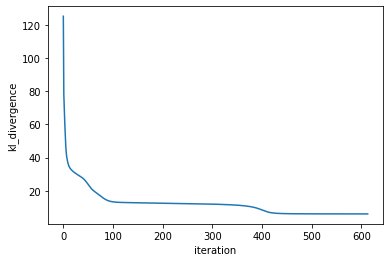

In [138]:
plt.plot([i for i in range(len(plot))], plot)
plt.xlabel("iteration")
plt.ylabel("kl_divergence")
plt.show()


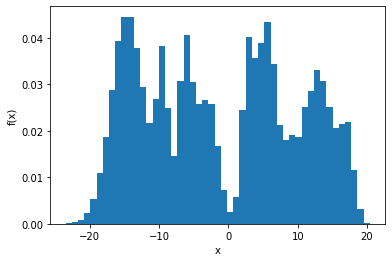

In [139]:
learned_mixture_index = np.random.choice(k, size = n, replace = True, p = predicted_weights)
learned_data = np.fromiter((np.random.normal(loc = predicted_mean[index], scale = np.sqrt([predicted_variance[index]])[0]) for index in learned_mixture_index), float)
assert data.shape == (n, )

plt.hist(learned_data, bins="auto", density=True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

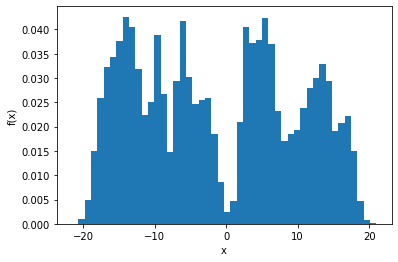

In [140]:
plt.hist(data, bins="auto", density=True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()